In [592]:
import pandas as pd
from dateutil.parser import parse
import h3

In [578]:
records = pd.read_pickle('output/waze_12_features.pkl')
labels = pd.read_pickle('output/waze_12_labels.pkl')

In [ ]:
def surroundings(r, regions, aperture_size):
    boundary = h3.h3_to_geo_boundary(h3.geo_to_h3(pt.y, pt.x, aperture_size))

In [581]:
records.head()

,time,reliability,r_86264d8dfffffff,r_86264d157ffffff,r_86264d177ffffff,r_86264d10fffffff,r_86264d11fffffff,r_86264d107ffffff,r_86264d117ffffff,r_86264d137ffffff,...,r_86264d887ffffff,r_86264d897ffffff,r_86264d147ffffff,r_86264d8a7ffffff,r_86264d8c7ffffff,r_86264d187ffffff,r_86264d1a7ffffff,r_86264dc67ffffff,r_86264dc77ffffff,r_86264dd5fffffff
0,2019-12-03 02:41:41,7,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-12-03 14:49:24,5,0.0,0.072373,0.382160,0.545467,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-12-03 14:46:04,10,0.0,0.000000,0.000000,0.152059,0.808363,0.039578,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-12-03 14:38:57,5,0.0,0.115842,0.401464,0.482694,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-12-03 14:34:57,10,0.0,0.012711,0.324826,0.662463,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [588]:
np.unique(records.reliability, return_counts=True)

(array([ 5,  6,  7,  8,  9, 10]), array([1447, 1038,  782,  603,  509, 1782]))

In [580]:
labels.loc[:, 'region'] = labels.hex6.apply(lambda x: 'r_' + x)

### Incident Time Intervel

- Definition: The average time taken for the arrival of first waze repot to the last waze report

In [475]:
labels.head()

,segment_id,time,lat,lng,timestamp,count,hex6,region
8,75,2019-12-19 16:06:00,36.33891,-86.91617,1.576772e+09,1,86264dc77ffffff,r_86264dc77ffffff
9,75,2019-12-08 20:18:00,36.33207,-86.90093,1.575836e+09,1,86264dd5fffffff,r_86264dd5fffffff
10,75,2019-12-08 22:45:00,36.33152,-86.90128,1.575845e+09,1,86264dd5fffffff,r_86264dd5fffffff
11,75,2019-12-09 13:04:00,36.33891,-86.91617,1.575897e+09,1,86264dc77ffffff,r_86264dc77ffffff
34,78,2019-12-15 20:01:00,36.32500,-86.87300,1.576440e+09,1,86264dc67ffffff,r_86264dc67ffffff


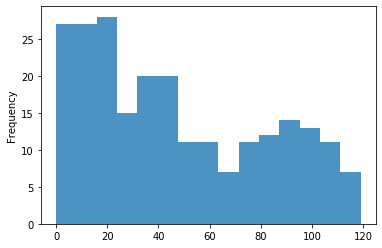

In [476]:
# calculate the time difference between two consecative incidents in same region
consec_inc_td = []

for region in labels.hex6.unique():
    time = labels[labels.hex6 == region].sort_values('time').time.diff().dropna().astype('timedelta64[m]')
    consec_inc_td += time[time.notnull()].tolist()
    
consec_inc_td_df = pd.Series(consec_inc_td).sort_values()

consec_inc_td_df[consec_inc_td_df < 120].plot.hist(bins=15, alpha=0.8)

In [477]:
# T' calculation

number_of_reports = []

pre_dt = timedelta(minutes=60)

for region in labels.hex6.unique():
    region_df = labels[labels.hex6 == region]
    col = 'r_' + region
    if col in records:
        records_after = records.loc[records[col] > 0, ['time', 'reliability', col]]
        for incident_time in region_df.time.sort_values():
            records_before = records_after[((incident_time - pre_dt) <= records_after.time) & (records_after.time <= incident_time)]
            time_intervels = (incident_time - records_before.sort_values('time').time).astype('timedelta64[m]')
            number_of_reports += time_intervels.tolist()
            records_after = records_after[records_after.time > incident_time]

In [478]:
# on average incident time is -- assuming all incidents are recorded the day of happening

np.average(number_of_reports_df[number_of_reports_df < 24])

7.867572156196944

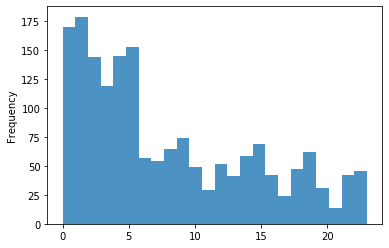

In [479]:
number_of_reports_df = pd.Series(number_of_reports).sort_values()

number_of_reports_df[number_of_reports_df < 24].plot.hist(bins=24, alpha=0.8, label='Time')

In [582]:
labels

,segment_id,time,lat,lng,timestamp,count,hex6,region
8,75,2019-12-19 16:06:00,36.33891,-86.91617,1.576772e+09,1,86264dc77ffffff,r_86264dc77ffffff
9,75,2019-12-08 20:18:00,36.33207,-86.90093,1.575836e+09,1,86264dd5fffffff,r_86264dd5fffffff
10,75,2019-12-08 22:45:00,36.33152,-86.90128,1.575845e+09,1,86264dd5fffffff,r_86264dd5fffffff
11,75,2019-12-09 13:04:00,36.33891,-86.91617,1.575897e+09,1,86264dc77ffffff,r_86264dc77ffffff
34,78,2019-12-15 20:01:00,36.32500,-86.87300,1.576440e+09,1,86264dc67ffffff,r_86264dc67ffffff
...,...,...,...,...,...,...,...,...
6921,2922,2019-12-30 14:00:00,36.12500,-86.73495,1.577714e+09,1,86264d10fffffff,r_86264d10fffffff
6922,2922,2019-12-04 16:47:00,36.12430,-86.74385,1.575478e+09,1,86264d10fffffff,r_86264d10fffffff
6923,2922,2019-12-04 19:15:00,36.12435,-86.74214,1.575487e+09,1,86264d10fffffff,r_86264d10fffffff
6924,2922,2019-12-09 23:27:00,36.12434,-86.74273,1.575934e+09,1,86264d10fffffff,r_86264d10fffffff


### Estimate posterior probabilities every 5 min (keep doing this up to T' min)

In [480]:
# change to historical data values
# P(I=1,R1)
def region_prior(region):
    # use labels_prv to prevent overfitting
    return sum(labels.region == region) / labels.shape[0]

np.sum([region_prior(r) for r in np.unique(labels.region)])

1.0

In [481]:
def p(r):
    return r / 10

In [482]:
def calculate_likelihood(m):
    c = m.reliability.apply(p)
    m.drop('reliability', axis=1, inplace=True)
    if m.shape[0] == 0:
        m.loc[0], c = np.zeros(m.shape[1]), 0
    return (m.T * c).T.prod(axis=0)

In [680]:
def calculate_posterior_v2(df, r, time_step=5):
    print(df[['reliability', 'time', 'r_86264d8dfffffff']].sort_values('time'))
    time_steps_records = df.set_index('time').resample(f'{time_step}T')
    likelihood = time_steps_records.apply(calculate_likelihood)
    print(f'Region Prior: {region_prior("r_86264d8dfffffff")}')
    print()
    print(likelihood['r_86264d8dfffffff'])
    region_priors = []
    sourrounding_region_priors = []
    for c in likelihood:
        region_priors.append(region_prior(c))
        if c in surroundings(r):
            sourrounding_region_priors.append(region_prior(c))
    region_priors = np.array(region_priors)
    likelihood.iloc[0, :] = region_priors * likelihood.iloc[0, :]
    p_n = likelihood.replace({0:np.nan}).cumprod(axis=0, skipna=True)
    print()
    print('p_n: ')
    print(p_n['r_86264d8dfffffff'])
    p_0 = (1 - np.sum(sourrounding_region_priors))
    print()
    print('p_0: ')
    print(p_0)
    l_0 = time_steps_records.apply(lambda m: (1 - m.reliability.apply(p)).prod())
    print()
    print('l_0: ')
    print(l_0)
    p_d = np.sum(p_n, axis=1) + p_0 * l_0
    print()
    print('p_d')
    print(p_d)
    posterior = p_n[r] / p_d
    print()
    print('Posterior: ')
    print(posterior)
    return likelihood.index, posterior

In [681]:
def incident_posterior_example(df, incident_interval=25):
    incident_interval = timedelta(minutes=incident_interval)
    features = []
    incident_id = 0
    col = 'r_86264d8dfffffff'
    df_region = df.loc[df[col] > 0, :]
    incident_time = parse('2019-12-03 14:02:39')
    incident_records = df_region[(incident_time <= df_region.time) & (df_region.time < (incident_time + incident_interval))]
    time_steps, posterior_probs = calculate_posterior_v2(incident_records, col)
    features_temp = []
    print(col, incident_time, len(time_steps))
    for time_step, posterior_proba in zip(time_steps, posterior_probs):
        features_temp.append({
            'incident_id': incident_id, 
            'start_time': incident_time,
            'end_time': incident_time + incident_interval,
            'time': time_step, 
            'region': col,
            'posterior_proba': posterior_proba,
        })
    features += features_temp
    incident_id = incident_id + 1
    return pd.DataFrame(features)

features = incident_posterior_example(records)

features.head()

     reliability                time  r_86264d8dfffffff
157           10 2019-12-03 14:02:39           1.000000
201           10 2019-12-03 14:02:39           1.000000
233            7 2019-12-03 14:02:39           1.000000
29            10 2019-12-03 14:09:57           1.000000
99            10 2019-12-03 14:09:57           1.000000
108            8 2019-12-03 14:09:57           1.000000
158            5 2019-12-03 14:09:57           1.000000
171           10 2019-12-03 14:09:57           1.000000
192           10 2019-12-03 14:09:57           1.000000
198            6 2019-12-03 14:09:57           1.000000
100           10 2019-12-03 14:10:15           0.988415
159            5 2019-12-03 14:10:15           0.988415
199            7 2019-12-03 14:10:15           0.988415
232           10 2019-12-03 14:10:15           0.988415
205            6 2019-12-03 14:22:28           1.000000
221            5 2019-12-03 14:22:28           1.000000
Region Prior: 0.01589242053789731

time
2019-12-

,incident_id,start_time,end_time,time,region,posterior_proba
0,0,2019-12-03 14:02:39,2019-12-03 14:27:39,2019-12-03 14:00:00,r_86264d8dfffffff,1.000000
1,0,2019-12-03 14:02:39,2019-12-03 14:27:39,2019-12-03 14:05:00,r_86264d8dfffffff,1.000000
2,0,2019-12-03 14:02:39,2019-12-03 14:27:39,2019-12-03 14:10:00,r_86264d8dfffffff,0.999993
3,0,2019-12-03 14:02:39,2019-12-03 14:27:39,2019-12-03 14:15:00,r_86264d8dfffffff,NaN
4,0,2019-12-03 14:02:39,2019-12-03 14:27:39,2019-12-03 14:20:00,r_86264d8dfffffff,0.007925


In [650]:
# number of incidents with the number of waze reports

pd.DataFrame(np.unique(features.groupby('incident_id').size(), return_counts=True))

,0
0,5
1,1


In [ ]:
np.unique(features.incident_id).size

# Incident Prediction

In [ ]:
# Map labels with records
def label_mapper(features, labels):
    mapped_labels = []
    for index, row in features.iterrows():
        label = labels[(labels.time >= row.start_time) & (labels.time < row.end_time) & (labels.region==row.region)]
        mapped_labels.append(label.shape[0] > 0)
    return mapped_labels

In [ ]:
features.loc[:,'label'] = label_mapper(features, labels)

In [ ]:
features.head()

In [ ]:
np.unique(features.label, return_counts=True)

In [ ]:
features.loc[:, 'hour'] = features.time.dt.hour

features.loc[:, 'is_peak'] = ((1 <= features.hour) & (features.hour <= 4)) | ((10 <= features.hour) & (features.hour <= 14))

features.head()

In [583]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

feature_extractor = ColumnTransformer([
    ('posterior_proba', 'passthrough', ['posterior_proba']),
    # ('is_peak', 'passthrough', ['is_peak']),
    ('hour_enc', OneHotEncoder(), ['hour']),
    ('region_enc', OneHotEncoder(), ['region']),
])

X = feature_extractor.fit_transform(features)
y = features.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg = LogisticRegression(random_state=42, class_weight='balanced').fit(X_train, y_train)

y_pred = reg.predict(X_test)

reg.score(X_test, y_test)

0.6279434850863422

In [584]:
reg.coef_ 

array([[ 1.3349265 ,  0.48184383,  0.06036677,  0.23893903, -0.67893761,
        -0.39292914,  0.0958879 , -0.7548151 , -0.90186194, -0.08578461,
        -0.87614939, -0.91163986,  1.21096103, -0.36400356,  0.34703687,
         0.28332549,  0.56405639,  0.2044631 ,  0.11711154,  0.30160048,
        -0.03955151, -0.49794313,  0.48776477,  0.45628167,  0.65509249,
         0.07725068,  1.43330738,  0.76775555, -0.72294842,  0.48128783,
         1.11928358,  1.07576694,  0.65055424, -1.25652766,  0.15531397,
        -1.48278338, -1.44874236, -0.91746109,  0.22023886,  0.09821691,
         0.43539316,  0.07035411,  0.62901703, -0.95790962,  0.26791641,
         0.75965457,  0.53025042, -1.11444292, -0.8696307 ]])

In [585]:
reg.intercept_

array([-2.03831405])

In [586]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.61      0.73       518
        True       0.29      0.71      0.41       119

    accuracy                           0.63       637
   macro avg       0.60      0.66      0.57       637
weighted avg       0.79      0.63      0.67       637

